In [7]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

# Set device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## DataLoader Module

In [8]:
class DataSetLoader:
    def __init__(self, data_dir="./data", batch_size=100):
        self.data_dir = data_dir
        self.batch_size = batch_size
        
    def load_mnist(self):
        # MNIST transforms - matching your original code
        compose = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
        
        # Download and load dataset - matching your approach
        out_dir = '{}/dataset'.format(self.data_dir)
        data = datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
        
        # Create data loader - matching your approach
        data_loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        num_batches = len(data_loader)
        
        # MNIST specifications
        img_size = [64, 64]
        channels = 1
        
        return data_loader, num_batches, img_size, channels
    
    def load_cifar10(self):
        # CIFAR10 transforms
        compose = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Download and load dataset
        out_dir = '{}/dataset'.format(self.data_dir)
        data = datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)
        
        # Create data loader
        data_loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        num_batches = len(data_loader)
        
        # CIFAR10 specifications
        img_size = [64, 64]
        channels = 3
        
        return data_loader, num_batches, img_size, channels

## GAN - Discriminator Module

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, out_channels=128,
                 kernel_size=3, stride=2, img_dim=[64, 64], final_size=None):
        super().__init__()
        
        # Use provided final_size or calculate it
        if final_size is None:
            # Calculate final spatial dimensions
            self.final_height = img_dim[0] // (stride**4)
            self.final_width = img_dim[1] // (stride**4)
        else:
            self.final_height, self.final_width = final_size
        
        self.out_channels = out_channels
        
        # nn layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * 2, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels * 4, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(out_channels * 4, out_channels * 8, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(out_channels * 8 * self.final_height * self.final_width, 1),
            nn.Sigmoid(),
        )
        
        print(f"Output size: {self.final_height}x{self.final_width}")
        print(f"out_channels: {out_channels*8}")

    def forward(self, x):
        # 4 conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

## GAN - Generator Module

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=128, out_channels=1, img_size=[28, 28], start_size=None):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        self.hidden_dim = hidden_dim
        
        # Use provided start_size or calculate it
        if start_size is None:
            # Calculate the starting size after 4 upsampling layers
            self.start_height = self.img_height // (2**4)
            self.start_width = self.img_width // (2**4)
        else:
            self.start_height, self.start_width = start_size
        
        # Linear layer to project noise to initial feature maps
        self.linear = nn.Linear(latent_dim, hidden_dim * 8 * self.start_height * self.start_width)
        print(f"latent_dim: {latent_dim}")
        print(f"hidden_dim: {hidden_dim*8}")
        print(f"start_height: {self.start_height}")
        print(f"start_width: {self.start_width}")
        # Upsampling layers (reverse of discriminator)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, x):
        # Project noise to initial feature maps
        x = self.linear(x)
        x = x.view(x.size(0), self.hidden_dim * 8, self.start_height, self.start_width)
        
        # Upsampling layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        return x

## GAN Module

In [11]:
class GAN:
    def __init__(self, latent_dim=100, img_size=[64, 64], channels=1, 
                 hidden_dim=128, out_channels=128, kernel_size=3, stride=2,
                 batch_size=128, lr=0.0002, device=None):
        
        # Set device
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"GAN initialized on device: {self.device}")
        
        # Parameters
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.channels = channels
        self.batch_size = batch_size
        self.lr = lr
        self.kernel_size = kernel_size
        self.stride = stride
        
        # Calculate dimensions dynamically
        self.discriminator_final_size = self._calculate_discriminator_final_size(img_size, kernel_size, stride)
        
        # Initialize networks with calculated dimensions
        self.generator = Generator(
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            out_channels=channels,
            img_size=img_size,
            start_size=self.discriminator_final_size  # Pass calculated start size
        ).to(self.device)
        
        self.discriminator = Discriminator(
            in_channels=channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            img_dim=img_size,
            final_size=self.discriminator_final_size  # Pass calculated final size
        ).to(self.device)
        
        # Initialize weights
        self.generator.apply(self.init_weights)
        self.discriminator.apply(self.init_weights)
        
        # Loss function
        self.loss = nn.BCELoss()
        
        # Optimizers
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        
        # Random noise for validation
        self.validation_z = torch.randn(batch_size, latent_dim, device=self.device)
    
    def _calculate_discriminator_final_size(self, img_size, kernel_size, stride, num_layers=4):
        h, w = img_size
        padding = 1  # Assuming padding=1 for all conv layers
        
        for _ in range(num_layers):
            # Convolution output size formula: (input + 2*padding - kernel) / stride + 1
            h = (h + 2*padding - kernel_size) // stride + 1
            w = (w + 2*padding - kernel_size) // stride + 1
        
        return [h, w]
    
    def _calculate_generator_start_size(self, img_size, kernel_size, stride, num_layers=4):
        return self._calculate_discriminator_final_size(img_size, kernel_size, stride, num_layers)
    
    def get_network_info(self):
        disc_final = self.discriminator_final_size
        gen_start = self._calculate_generator_start_size(self.img_size, self.kernel_size, self.stride)
        
        return {
            'input_size': self.img_size,
            'discriminator_final_size': disc_final,
            'generator_start_size': gen_start,
            'channels': self.channels,
            'latent_dim': self.latent_dim,
            'hidden_dim': getattr(self.generator, 'hidden_dim', 'N/A'),
            'out_channels': getattr(self.discriminator, 'out_channels', 'N/A'), 
            'device': str(self.device)
        }
    
    def init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
            m.weight.data.normal_(0.00, 0.02)
    
    def noise(self, size):
        return torch.randn(size, self.latent_dim, device=self.device)
    
    def real_data_target(self, size):
        return torch.ones(size, 1, device=self.device)
    
    def fake_data_target(self, size):
        return torch.zeros(size, 1, device=self.device)
    
    def train_discriminator(self, real_data, fake_data):
        # Reset gradients
        self.d_optimizer.zero_grad()
        
        # Train on Real Data
        prediction_real = self.discriminator(real_data)
        error_real = self.loss(prediction_real, self.real_data_target(real_data.size(0)))
        error_real.backward()

        # Train on Fake Data
        prediction_fake = self.discriminator(fake_data)
        error_fake = self.loss(prediction_fake, self.fake_data_target(real_data.size(0)))
        error_fake.backward()
        
        # Update weights
        self.d_optimizer.step()
        
        return error_real + error_fake, prediction_real, prediction_fake

    def train_generator(self, fake_data):
        # Reset gradients
        self.g_optimizer.zero_grad()
        
        # Sample noise and generate fake data
        prediction = self.discriminator(fake_data)
        error = self.loss(prediction, self.real_data_target(prediction.size(0)))
        error.backward()
        
        # Update weights
        self.g_optimizer.step()
        
        return error
    
    def train_step(self, real_imgs):
        
        #real images to device
        real_imgs = real_imgs.to(self.device)
        
        # Generate fake data for discriminator training
        fake_data = self.generator(self.noise(real_imgs.size(0))).detach()
        
        # 1. Train Discriminator
        d_error, d_pred_real, d_pred_fake = self.train_discriminator(real_imgs, fake_data)
        
        # 2. Train Generator
        fake_data = self.generator(self.noise(real_imgs.size(0)))
        g_error = self.train_generator(fake_data)
        
        return {
            "d_loss": d_error.item(),
            "g_loss": g_error.item(),
            "d_pred_real": d_pred_real.mean().item(),
            "d_pred_fake": d_pred_fake.mean().item()
        }
    
    def generate_samples(self, num_samples=16):
        """Generate sample images"""
        with torch.no_grad():
            noise = self.noise(num_samples)
            samples = self.generator(noise)
            return samples.cpu().detach()
    
    def plot_samples(self, num_samples=16):
        """Plot generated samples"""
        samples = self.generate_samples(num_samples)
        
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for i in range(min(16, num_samples)):
            row, col = i // 4, i % 4
            
            # Get the sample and convert to numpy
            sample = samples[i].numpy()
            
            # Handle different channel configurations
            if sample.ndim == 3:  # (C, H, W) format
                if sample.shape[0] == 1:  # Grayscale
                    img = sample.squeeze(0)  # Remove channel dimension
                    axes[row, col].imshow(img, cmap='gray')
                elif sample.shape[0] == 3:  # RGB
                    img = sample.transpose(1, 2, 0)  # Convert to (H, W, C)
                    # Denormalize from [-1, 1] to [0, 1] range
                    img = (img + 1) / 2
                    axes[row, col].imshow(img)
                else:
                    # Handle other channel configurations
                    img = sample.transpose(1, 2, 0)
                    axes[row, col].imshow(img)
            else:  # Already 2D (H, W)
                axes[row, col].imshow(sample, cmap='gray')
            
            axes[row, col].axis('off')
        plt.tight_layout()
        plt.show()
    
    def save_models(self, path):
        """Save generator and discriminator"""
        torch.save({
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'network_info': self.get_network_info(),  # Save network configuration
        }, path)
    
    def load_models(self, path):
        """Load generator and discriminator"""
        checkpoint = torch.load(path, map_location=self.device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

Files already downloaded and verified
Data loader: <torch.utils.data.dataloader.DataLoader object at 0x7f272461fed0>
Number of batches: 391
Image size: [64, 64]
Channels: 3
GAN initialized on device: cuda
latent_dim: 100
hidden_dim: 512
start_height: 4
start_width: 4
Output size: 4x4
out_channels: 1024
Training for 50 epochs
Network info: {'input_size': [64, 64], 'discriminator_final_size': [4, 4], 'generator_start_size': [4, 4], 'channels': 3, 'latent_dim': 100, 'hidden_dim': 64, 'out_channels': 128, 'device': 'cuda'}
Epoch [0/50] Batch [0/391] D_loss: 1.3830 G_loss: 0.7386
Epoch [0/50] Batch [100/391] D_loss: 0.0988 G_loss: 3.4262
Epoch [0/50] Batch [200/391] D_loss: 0.0931 G_loss: 3.4095
Epoch [0/50] Batch [300/391] D_loss: 1.8364 G_loss: 2.3002


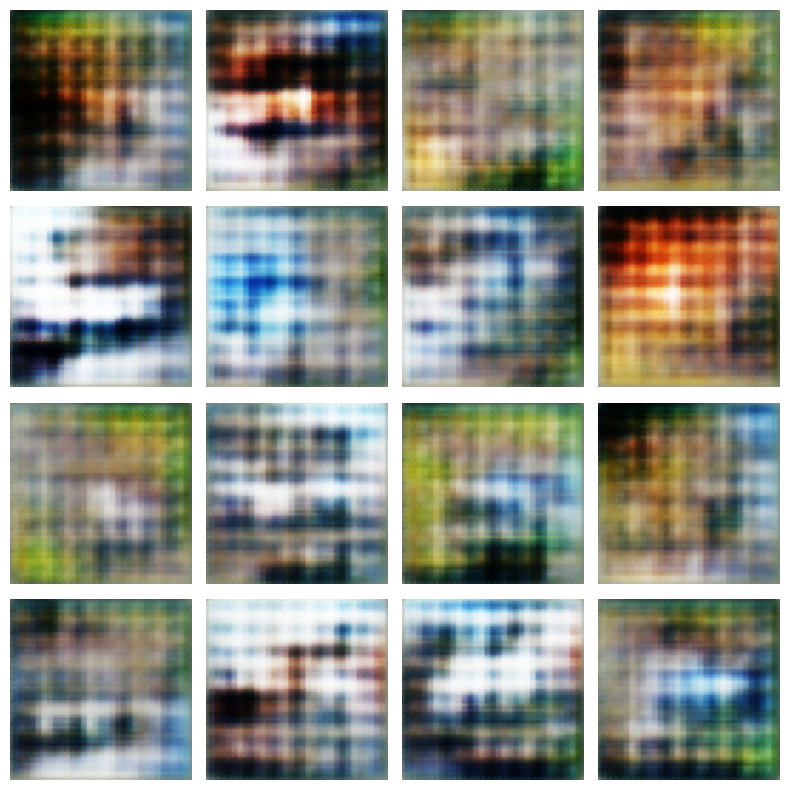

Epoch [1/50] Batch [0/391] D_loss: 1.8566 G_loss: 2.3797
Epoch [1/50] Batch [100/391] D_loss: 1.9278 G_loss: 1.5696
Epoch [1/50] Batch [200/391] D_loss: 1.7482 G_loss: 3.0805
Epoch [1/50] Batch [300/391] D_loss: 1.1353 G_loss: 2.2406
Epoch [2/50] Batch [0/391] D_loss: 0.7974 G_loss: 1.4367
Epoch [2/50] Batch [100/391] D_loss: 0.9160 G_loss: 2.1025
Epoch [2/50] Batch [200/391] D_loss: 1.4588 G_loss: 4.0867
Epoch [2/50] Batch [300/391] D_loss: 1.0251 G_loss: 1.7213
Epoch [3/50] Batch [0/391] D_loss: 1.1435 G_loss: 1.5212
Epoch [3/50] Batch [100/391] D_loss: 0.8247 G_loss: 1.4520
Epoch [3/50] Batch [200/391] D_loss: 0.9698 G_loss: 1.2858
Epoch [3/50] Batch [300/391] D_loss: 1.1160 G_loss: 3.5209
Epoch [4/50] Batch [0/391] D_loss: 0.7747 G_loss: 1.8410
Epoch [4/50] Batch [100/391] D_loss: 0.5696 G_loss: 1.6165
Epoch [4/50] Batch [200/391] D_loss: 0.4020 G_loss: 2.6325
Epoch [4/50] Batch [300/391] D_loss: 0.2891 G_loss: 2.3872
Epoch [5/50] Batch [0/391] D_loss: 0.2724 G_loss: 3.1401
Epoch [

In [ ]:
# Initialize dataset class
dataset = DataSetLoader(batch_size=128, data_dir='./data')

#data loader 
# data_loader, num_batches, img_size, channels = dataset.load_mnist()
# print(f"Data loader: {data_loader}")
# print(f"Number of batches: {num_batches}")
# print(f"Image size: {img_size}")
# print(f"Channels: {channels}")

#load cifar10
data_loader, num_batches, img_size, channels = dataset.load_cifar10()
print(f"Data loader: {data_loader}")
print(f"Number of batches: {num_batches}")
print(f"Image size: {img_size}")
print(f"Channels: {channels}")

# # Initialize GAN with MNIST specifications
# gan_mnist = GAN(
#     latent_dim=100,
#     img_size=img_size,
#     channels=channels,
#     hidden_dim=128,
#     out_channels=128,
#     kernel_size=3,
#     stride=2,
#     batch_size=100  ,
#     lr=0.0002
# )


# Initialize GAN with CIFAR10 specifications
gan_cifar = GAN(
    latent_dim=100,
    img_size=img_size,
    channels=channels,
    hidden_dim=64,
    out_channels=128,
    kernel_size=3,
    stride=2,
    batch_size=128,
    lr=0.0002
)

# Training loop
num_epochs = 50
print(f"Training for {num_epochs} epochs")
print(f"="*150)
print(f"Network info: {gan_cifar.get_network_info()}")


for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        
        real_imgs = real_imgs.to(device)
        
        # Train step
        losses = gan_cifar.train_step(real_imgs)
        
        # Log progress
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(data_loader)}] "
                  f"D_loss: {losses['d_loss']:.4f} G_loss: {losses['g_loss']:.4f}")
    if epoch % 10 == 0:
        #plot samples
        gan_cifar.plot_samples()